In [47]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

In [48]:
def plot_hist(features): # Построение гистограм
    for feature in features:
        plt.figure(figsize=(6,3))
        display(features[feature].hist())
        plt.title(feature)
        
def plot_boxplots(features): # Построение boxpots
    for feature in features:
        plt.figure(figsize=(6,3))
        sns.boxplot(features[feature], color = 'blue')
        print('Среднее значение {} = {:.3f}'.format(feature, features[feature].mean()))

def plot_corr_heatmap(features): # Построение корреляционой матрицы с наложением heatmap 
    def magnify():
        return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

    corr = features.corr()

    cmap = sns.diverging_palette(5, 250, as_cmap=True)

    display(corr.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magnify")\
        .set_precision(2)\
        .set_table_styles(magnify()))
    
def plot_feature_ranking(features): # Определение наиболее весомых признаков
    imp_num = pd.Series(f_classif(features, df['default'])[0], 
                    index = features.columns)
    imp_num.sort_values(inplace = True)
    print(imp_num)
    imp_num.plot(kind = 'barh')
    
def outliers_iqr(col): #Избавление числового признака от выбросов
        quartile_1, quartile_3 = np.percentile(list(col), [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return df[col < upper_bound][col > lower_bound]

def education_to_int(item):
    if item == 'SCH':
        return 1
    elif item == 'UGR':
        return 2
    elif item == 'GRD':
        return 3
    elif item == 'PGR':
        return 4
    elif item == 'ACD':
        return 5

# Первичный анализ сырых данных

In [49]:
df = pd.read_csv('C:/Users/enasy/Downloads/Project/train.csv')
df.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
5,41415,18FEB2014,SCH,M,27,Y,N,0,1,-2.032257,0,50,1,1,15000,2,3,N,0
6,28436,04FEB2014,SCH,M,39,N,N,0,0,-2.225004,0,60,1,2,28000,1,1,N,0
7,68769,17MAR2014,SCH,F,39,N,N,0,0,-1.522739,1,50,2,3,45000,3,3,N,0
8,38424,14FEB2014,SCH,F,50,Y,N,1,0,-1.676061,0,50,1,1,30000,1,4,N,0
9,4496,10JAN2014,UGR,F,54,N,N,0,0,-2.695176,1,50,2,3,24000,1,3,N,0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [51]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [52]:
df.corr()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
client_id,1.000000,0.015435,-0.021417,0.004749,-0.063293,-0.029028,0.008233,0.165555,0.165777,-0.000099,-0.004195,0.017277,-0.039242
age,0.015435,1.000000,-0.111175,-0.076158,-0.106275,0.046265,-0.089501,0.010392,-0.006299,-0.018900,-0.059542,0.079046,-0.025004
decline_app_cnt,-0.021417,-0.111175,1.000000,-0.027359,0.189987,0.155894,-0.038505,0.012530,0.016234,-0.021687,0.065297,-0.069099,0.113682
good_work,0.004749,-0.076158,-0.027359,1.000000,0.006269,0.005738,0.073041,-0.003624,-0.008535,0.022705,-0.054041,0.055821,-0.043361
score_bki,-0.063293,-0.106275,0.189987,0.006269,1.000000,0.156257,0.008959,0.013847,0.012648,-0.012639,0.067623,-0.069122,0.175369
bki_request_cnt,-0.029028,0.046265,0.155894,0.005738,0.156257,1.000000,0.009025,0.008183,0.005553,0.082983,0.005139,0.014859,0.078242
region_rating,0.008233,-0.089501,-0.038505,0.073041,0.008959,0.009025,1.000000,0.233820,0.253541,0.205674,-0.078199,0.088777,-0.089035
home_address,0.165555,0.010392,0.012530,-0.003624,0.013847,0.008183,0.233820,1.000000,0.728139,0.038343,0.115196,-0.058476,0.084637
work_address,0.165777,-0.006299,0.016234,-0.008535,0.012648,0.005553,0.253541,0.728139,1.000000,0.049721,0.111114,-0.063202,0.081582
income,-0.000099,-0.018900,-0.021687,0.022705,-0.012639,0.082983,0.205674,0.038343,0.049721,1.000000,-0.087800,0.109893,-0.039752


# Наивная модель

ROC AUC = 0.572


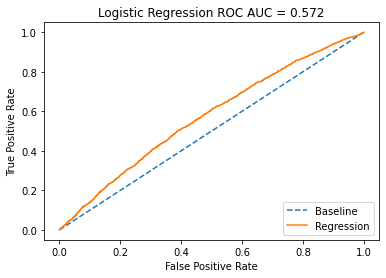

In [53]:
df = pd.read_csv('C:/Users/enasy/Downloads/Project/train.csv')

df.dropna(inplace=True)
X = df.drop(['client_id', 'app_date', 'education', 'sex', 'car', 'car_type', 'foreign_passport', 'default'], axis = 1)
Y = df['default']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('ROC AUC = {:.3f}'.format(roc_auc))


# EDA с Pandas Profiling

In [54]:
df = pd.read_csv('C:/Users/enasy/Downloads/Project/train.csv')

In [55]:
!pip install pandas_profiling

In [56]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='C:/Users/enasy/Downloads/Project/Pandas_Profiling_Report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Более глубокий анализ и визуализация данных 

## Пропуски

In [57]:
df = pd.read_csv('C:/Users/enasy/Downloads/Project/train.csv')

In [58]:
# Из первичного осмотра данных и Pandas Profiling видно что education - единственный столбец который содержит пропуски,
# посчитаем их
print(df['education'].isna().value_counts())
# Видим что пропусков не так уж и много


False    73492
True       307
Name: education, dtype: int64


## Классификация признаков

In [59]:
# Сгруппируем признаки по классам: числовые и категоральные отдельно выделив бинарные. 
# Опять же таки, класс признаков виден из первичного анализа и Pandas Profiling
print(df.columns)
# столбец client_id не явдяется признаком и не будет прередаваться в модель
num_col = df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']]
bin_col = df[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]
cat_col = df[['education', 'home_address', 'work_address', 'sna', 'first_time']]
# Остаётся столбец app_date с которым нужно будет поработать отдельно переведя значения во временой формат 

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')


## Визуальзация данных

### Визуализация числовых признаков

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

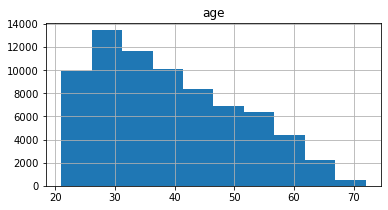

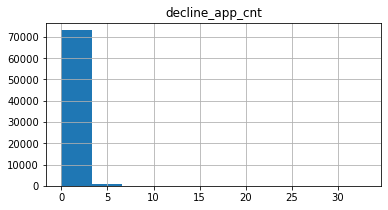

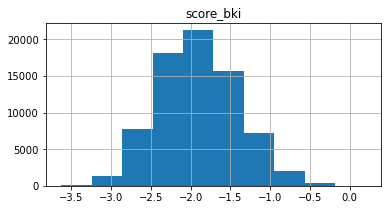

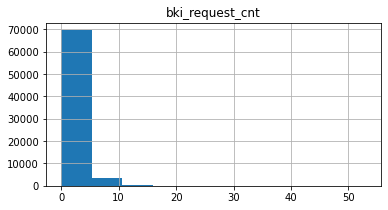

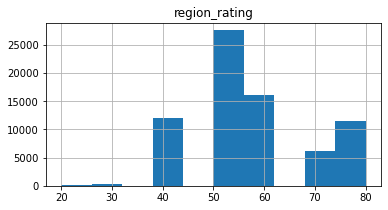

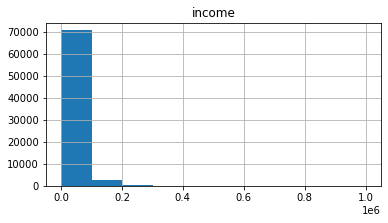

In [60]:
# Построение гистограм
plot_hist(num_col)
# Видим что признаки decline_app_cnt, bki_request_cnt и income имеют длиные хвосты

Среднее значение age = 39.281
Среднее значение decline_app_cnt = 0.276
Среднее значение score_bki = -1.905
Среднее значение bki_request_cnt = 2.000
Среднее значение region_rating = 56.726
Среднее значение income = 41099.775


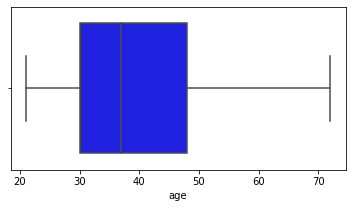

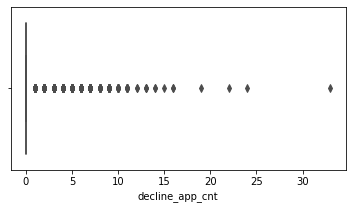

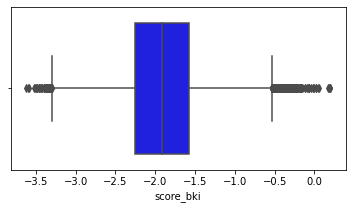

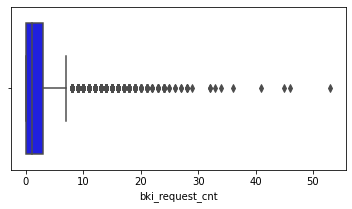

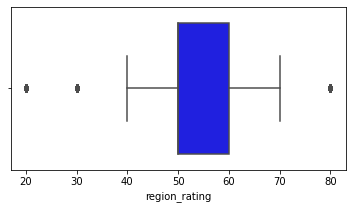

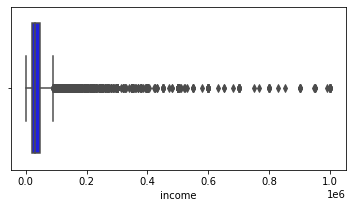

In [61]:
# Построение boxpots
plot_boxplots(num_col)
# Видим что присутствуют выбросы

In [62]:
# Построение корреляционой матрицы с наложением heatmap 
plot_corr_heatmap(num_col)
# Видим что сильные корреляции между числовыми признаками отсутствуют, наиболее высокий коэффициент наблюдается между 
# region_rating и income что логично, но и он не очень высок (0.21)

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
age,1.00,-0.11,-0.11,0.05,-0.09,-0.02
decline_app_cnt,-0.11,1.00,0.19,0.16,-0.04,-0.02
score_bki,-0.11,0.19,1.00,0.16,0.01,-0.01
bki_request_cnt,0.05,0.16,0.16,1.00,0.01,0.08
region_rating,-0.09,-0.04,0.01,0.01,1.00,0.21
income,-0.02,-0.02,-0.01,0.08,0.21,1.00


age                  46.166168
income              116.798014
bki_request_cnt     454.555786
region_rating       589.678381
decline_app_cnt     966.206975
score_bki          2341.599450
dtype: float64


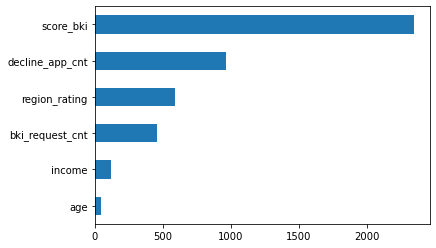

In [63]:
# Определение наиболее весомых признаков
plot_feature_ranking(num_col)
# Видим что признак score_bki является наиболее весомым что логично, интересно что income не является сильнозначимым

### Визуализация категоральных признаков

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

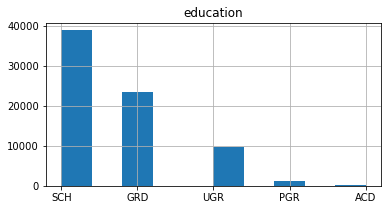

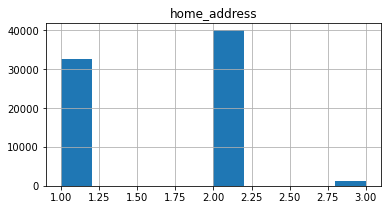

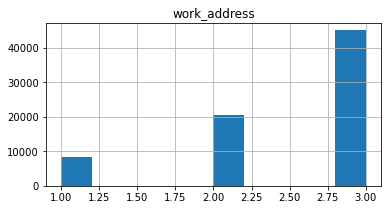

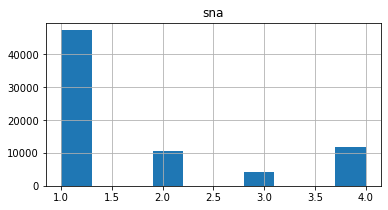

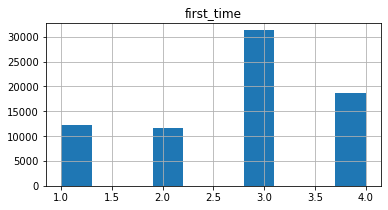

In [64]:
# Построение гистограм
plot_hist(cat_col)
# Видим что категоральные признаки без сюрпризов 

In [65]:
# Построение корреляционой матрицы с наложением heatmap 
plot_corr_heatmap(cat_col)
# Видим что очень сильна корреляция между work_address и home_address что логично, также интерсна сильная корреляция
# между sna и first_time

,home_address,work_address,sna,first_time
home_address,1.00,0.73,0.12,-0.06
work_address,0.73,1.00,0.11,-0.06
sna,0.12,0.11,1.00,-0.53
first_time,-0.06,-0.06,-0.53,1.00


work_address     494.460260
home_address     532.449810
first_time       831.876810
sna             1187.281038
dtype: float64


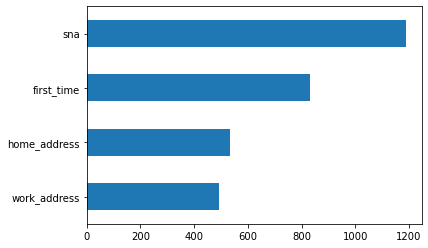

In [66]:
# Определение наиболее весомых признаков
# столбец education нужно будет привести к численному виду, пока просто не будем его брать в рассчёт 
plot_feature_ranking(cat_col.drop(['education'], axis = 1))
# Видим что признак sna является наиболее весомым

### Визуализация бинарных признаков

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

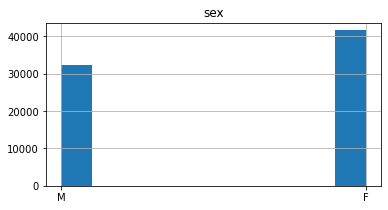

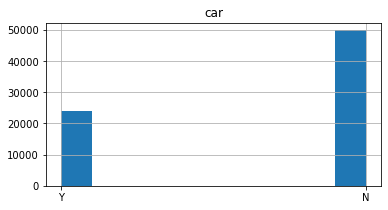

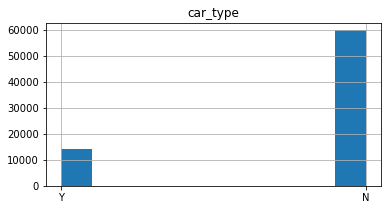

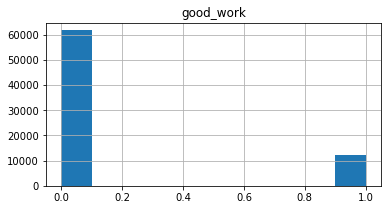

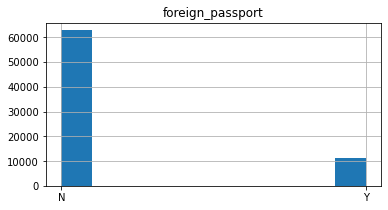

In [67]:
# Построение гистограм
plot_hist(bin_col)
# Видим что бинарные признаки без сюрпризов

In [68]:
# Для построения корреляционой матрицы и выявленния наиболее весомых признаков
# надо будет привести признаки к численным значениям

# Обработка данных

In [69]:
df = pd.read_csv('C:/Users/enasy/Downloads/Project/train.csv')

## Пропуски

In [70]:
# Заполним поропуски значением SCH ибо школьное образование является обязательным минимумом.
df['education'].fillna('SCH', inplace = True)

## Устранение дисбаланса

In [71]:
df.default.value_counts()
# Видим что пресутствует дисбаланс который может повлиять на качество модели

0    64427
1     9372
Name: default, dtype: int64

In [72]:
# Сделаем данные сбалансированными
default_1 = df[df.default == 1.0]
default_0 = df[df.default == 0.0].head(len(default_1))
df = default_1.append(default_0)
df.default.value_counts()

0    9372
1    9372
Name: default, dtype: int64

## Работа со столбцом времени

Среднее значение time_relevance = 5142809.731
False    11737
True      7007
Name: time_relevance, dtype: int64


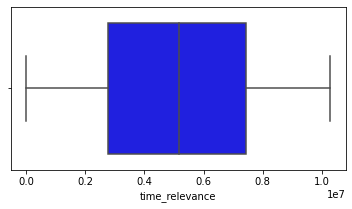

In [73]:
# Приведём данные в столбце app_date к формату datetime, создадим новый столбец time_relevance c
# числовыми даннами нормализованными относительно самой ранней заявки проверив ны выбросы перед нормализацией.
# Заполним пустые значения средней величиной
df['app_date'] = pd.to_datetime(df['app_date'])
earliest_app = df['app_date'].min()
df['time_relevance'] = df['app_date'].apply(lambda x: (x-earliest_app).total_seconds())
plot_boxplots(df[['time_relevance']])
x = np.asmatrix(df['time_relevance'])
x_scaled = MinMaxScaler().fit_transform(x.T)
df['time_relevance'] = pd.DataFrame(x_scaled)
print(df['time_relevance'].isna().value_counts())
df['time_relevance'].fillna(df['time_relevance'].mean(), inplace=True)

## Обработка числовых признаков

In [74]:
# Извавимся от длинных хвостов логарифмированием.
for col in df[['decline_app_cnt', 'bki_request_cnt', 'income']]:
    df[col] = df[col].apply(lambda x: np.log(x+1))

In [75]:
# Избавимся от выбросов во всех числовых признаках за исключением age, decline_app_cnt и time_relevance
# (они чистенькие).
# Выяснилось что удаление выбросов сильно понижает AUC хоть и немного добавляет к другим метрикам. Решено оставить.
#len_original_df = len(df)
#for col in df[['score_bki', 'bki_request_cnt', 'region_rating', 'income']]:
#    df = outliers_iqr(df[col])

#Посмотрим на новые boxplots числовых признаков
#display(plot_boxplots(df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating',
#                         'income', 'time_relevance']]))
#Посмотрим сколько значений бюло удалено
#len_new_df = len(df)
#print('Удалено {:.2f} % данных'.format(((len_original_df - len_new_df)/len_original_df)*100))

In [76]:
# Посмотрим на матрицу корреляций
plot_corr_heatmap(df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating',
                    'income', 'time_relevance']])
# Отметим что новые признаки сильно коллерированы с начальными. 
# Метрики они не повысили так что решено их не брать в модель.

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,time_relevance
age,1.00,-0.13,-0.09,0.06,-0.07,-0.12,-0.00
decline_app_cnt,-0.13,1.00,0.23,0.14,-0.04,-0.01,-0.00
score_bki,-0.09,0.23,1.00,0.15,0.01,-0.00,0.01
bki_request_cnt,0.06,0.14,0.15,1.00,-0.01,0.10,0.02
region_rating,-0.07,-0.04,0.01,-0.01,1.00,0.29,-0.01
income,-0.12,-0.01,-0.00,0.10,0.29,1.00,-0.00
time_relevance,-0.00,-0.00,0.01,0.02,-0.01,-0.00,1.00


time_relevance        5.569537
age                  19.668021
income              138.716919
bki_request_cnt     270.127683
region_rating       363.728653
decline_app_cnt     541.892811
score_bki          1392.798460
dtype: float64


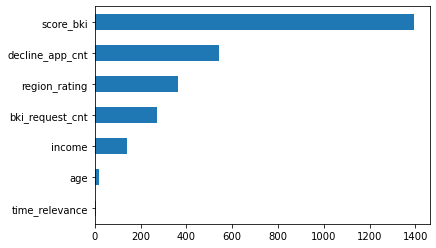

In [77]:
# Посмотрим на весомость числовых признаков
plot_feature_ranking(df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating',
                    'income', 'time_relevance']])

## Попробуем сгенерировать новые числовые признаки

In [78]:
# Довавим столбцы с доходами соответствующими возрасту
mean_income = df.groupby('age')['income'].mean().to_dict()
df['mean_income_age'] = df['age'].map(mean_income)
max_income = df.groupby('age')['income'].max().to_dict()
df['max_income_age'] = df['age'].map(max_income)
df['normalized_income'] = abs((df.income - df.mean_income_age)/df.max_income_age)

In [79]:
# Добавим столбец со средним количеством запросов соответствующими возрасту
mean_bki = df.groupby('age')['bki_request_cnt'].mean().to_dict()
df['mean_requests_age'] = df['age'].map(mean_bki)

In [80]:
# Добавим столбец со средним доходом по региону
mean_income_rat = df.groupby('region_rating')['income'].mean().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_income_rat)

In [81]:
# Посмотрим на матрицу корреляций
plot_corr_heatmap(df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating',
                    'income', 'time_relevance', 'mean_income_age', 'max_income_age', 'normalized_income',
                    'mean_requests_age', 'mean_income_region']])
# Отметим что новые признаки сильно коллерированы с начальными. 
# Метрики они при тестировании не повысили так что решено их не брать в модель.

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,time_relevance,mean_income_age,max_income_age,normalized_income,mean_requests_age,mean_income_region
age,1.00,-0.13,-0.09,0.06,-0.07,-0.12,-0.00,-0.54,0.11,0.11,0.42,-0.07
decline_app_cnt,-0.13,1.00,0.23,0.14,-0.04,-0.01,-0.00,0.04,-0.05,-0.05,-0.08,-0.04
score_bki,-0.09,0.23,1.00,0.15,0.01,-0.00,0.01,0.02,-0.03,-0.02,-0.03,0.02
bki_request_cnt,0.06,0.14,0.15,1.00,-0.01,0.10,0.02,0.01,0.05,0.01,0.14,-0.01
region_rating,-0.07,-0.04,0.01,-0.01,1.00,0.29,-0.01,0.03,-0.02,0.05,-0.05,0.92
income,-0.12,-0.01,-0.00,0.10,0.29,1.00,-0.00,0.22,0.09,0.16,0.02,0.31
time_relevance,-0.00,-0.00,0.01,0.02,-0.01,-0.00,1.00,0.00,0.01,0.01,0.01,-0.00
mean_income_age,-0.54,0.04,0.02,0.01,0.03,0.22,0.00,1.00,0.42,-0.03,0.09,0.03
max_income_age,0.11,-0.05,-0.03,0.05,-0.02,0.09,0.01,0.42,1.00,0.02,0.38,-0.02
normalized_income,0.11,-0.05,-0.02,0.01,0.05,0.16,0.01,-0.03,0.02,1.00,0.07,0.06


## Стандартизация числовых признаков

In [82]:
# Стандартизируем числовые признаки и запишем их в переменную numpy
X_num = StandardScaler().fit_transform(df[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating',
                    'income', 'time_relevance']].values)
print('Размерность числовых признаков: {}'.format(X_num.shape))

Размерность числовых признаков: (18744, 7)


## Обработка категоральных признаков

In [83]:
# Переведём категоральные значения столбца education в числа
df['education'].update(df['education'].apply(education_to_int))
df['education'] = pd.to_numeric(df['education'])

,education,home_address,work_address,sna,first_time
education,1.00,-0.01,-0.02,-0.11,0.12
home_address,-0.01,1.00,0.75,0.15,-0.07
work_address,-0.02,0.75,1.00,0.15,-0.08
sna,-0.11,0.15,0.15,1.00,-0.50
first_time,0.12,-0.07,-0.08,-0.50,1.00


home_address    304.197255
work_address    322.573150
education       329.378992
first_time      433.055529
sna             633.062071
dtype: float64


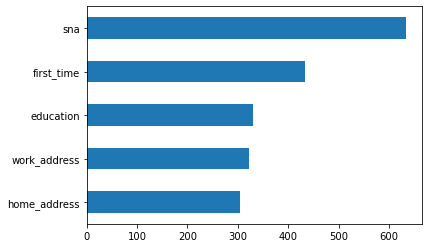

In [84]:
# Посмотрим корреляцию между карегоральными признаками и их значимость
plot_corr_heatmap(df[['education', 'home_address', 'work_address', 'sna', 'first_time']])
plot_feature_ranking(df[['education', 'home_address', 'work_address', 'sna', 'first_time']])
# Признаки home_address и first_time существенно добавили к метрикам на тесте несмотря на их сильную коррелируемость
# с work_address и sna. Решено их оставить.

In [85]:
# Разложем значимые категоральные признаки на бинарные и запишем их в переменную numpy
X_cat = OneHotEncoder(sparse = False).fit_transform(df[['education', 'work_address', 'home_address',
                                                        'sna', 'first_time']].values)

print('Размерность категоральных признаков: {}'.format(X_cat.shape))

Размерность категоральных признаков: (18744, 19)


## Обработка бинарных признаков

In [86]:
# Переведём бинарные признаки в числовой формат
label_encoder = LabelEncoder()
for column in df[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    df[column] = label_encoder.fit_transform(df[column])

,sex,car,car_type,good_work,foreign_passport
sex,1.00,0.27,0.21,-0.05,0.08
car,0.27,1.00,0.68,0.00,0.11
car_type,0.21,0.68,1.00,0.02,0.15
good_work,-0.05,0.00,0.02,1.00,0.05
foreign_passport,0.08,0.11,0.15,0.05,1.00


sex                  16.689435
good_work            76.161578
car                  83.689297
car_type            170.851258
foreign_passport    224.272659
dtype: float64


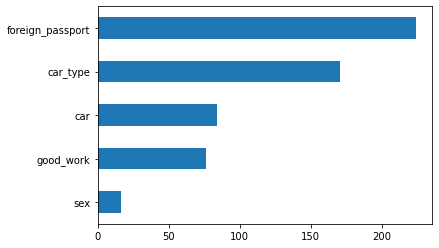

In [87]:
# Посмотрим корреляцию между карегоральными признаками и их значимость
plot_corr_heatmap(df[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']])
plot_feature_ranking(df[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']])
# Видим что признак car стоит исключить из модели из-за сильной коррелируемости с car_type и меньшей значимости

In [88]:
# Запишем значимые бинарные признаки в переменную numpy
X_bin = df[['sex', 'car_type', 'good_work', 'foreign_passport']].values

print('Размерность бинарных признаков: {}'.format(X_bin.shape))

Размерность бинарных признаков: (18744, 4)


# Моделирование

ROC AUC = 0.734
Confusion matrix:
[[1248  614]
 [ 630 1257]]
Accuracy score = 0.668
Precision score = 0.672
Recall score = 0.666
f1 score = 0.669


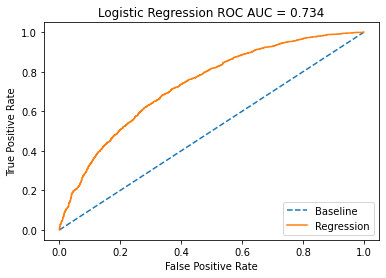

In [89]:
X = np.hstack([X_num, X_cat, X_bin])
Y = df['default'].values

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_val)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('ROC AUC = {:.3f}'.format(roc_auc))

y_predicted = model.predict(X_val)

conf_mat = confusion_matrix(y_val, y_predicted)
print('Confusion matrix:\n{}'.format(conf_mat))

print('Accuracy score = {:.3f}'.format(accuracy_score(y_val,y_predicted)))
print('Precision score = {:.3f}'.format(precision_score(y_val,y_predicted)))
print('Recall score = {:.3f}'.format(recall_score(y_val,y_predicted)))
print('f1 score = {:.3f}'.format(f1_score(y_val,y_predicted)))

# Поиск гиперпараметров и их довавление в модель

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l1'
	random_state: None
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
ROC AUC = 0.734
Confusion matrix:
[[1246  616]
 [ 626 1261]]
Accuracy score = 0.669
Precision score = 0.672
Recall score = 0.668
f1 score = 0.670


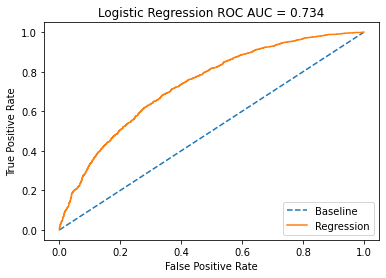

In [90]:
from sklearn.model_selection import GridSearchCV

# Задаём критерии поиска по сетке
iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

# Ищем лучшие параметры и добавляем их в модель
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

# Печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

# Печатаем метрики полученые моделью с гиперпараметрами
probs = model.predict_proba(X_val)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('ROC AUC = {:.3f}'.format(roc_auc))

y_predicted = model.predict(X_val)

conf_mat = confusion_matrix(y_val, y_predicted)
print('Confusion matrix:\n{}'.format(conf_mat))

print('Accuracy score = {:.3f}'.format(accuracy_score(y_val,y_predicted)))
print('Precision score = {:.3f}'.format(precision_score(y_val,y_predicted)))
print('Recall score = {:.3f}'.format(recall_score(y_val,y_predicted)))
print('f1 score = {:.3f}'.format(f1_score(y_val,y_predicted)))

### Общие выводы
1) Оценки в общем и целом получились сбалансированными хоть ROC AUC и невысок

2) Чрезвычайно выжным моментом было устранение дисбаланса тестовой выборки для поднятия всех метрик на приемлемый уровень

3) Сырые данные достаточно чистенькие, работы с ними было немного

4) Удивительно что удаление выпросов имело негативный эфект 

5) Попытки генерации новых признаков из имеющихся не привели к значимому успеху

6) Поиск и добавление гиперпараметров лишь незначительно улучшило метрики

In [91]:
# Обрабатываем тестовые данные аналогичным образом и отправляем в модель

test = pd.read_csv('C:/Users/enasy/Downloads/Project/test.csv')

test['education'].fillna('SCH', inplace = True)

test['app_date'] = pd.to_datetime(test['app_date'])
earliest_app = test['app_date'].min()
test['time_relevance'] = test['app_date'].apply(lambda x: (x-earliest_app).total_seconds())
x_test = np.asmatrix(test['time_relevance'])
x_scaled_test = MinMaxScaler().fit_transform(x_test.T)
test['time_relevance'] = pd.DataFrame(x_scaled_test)
test['time_relevance'].fillna(test['time_relevance'].mean(), inplace=True)
        
X_num_test = StandardScaler().fit_transform(test[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
                                           'region_rating', 'income', 'time_relevance']].values)

test['education'].update(test['education'].apply(education_to_int))
test['education'] = pd.to_numeric(test['education'])

X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[['education', 'work_address', 'home_address',
                                                        'sna', 'first_time']].values)

for column in test[['sex', 'car', 'car_type', 'good_work', 'foreign_passport']]:
    test[column] = label_encoder.fit_transform(test[column])

X_bin_test = test[['sex', 'car_type', 'good_work', 'foreign_passport']].values

X_test = np.hstack([X_num_test, X_cat_test, X_bin_test])

predicted_val = model.predict_proba(X_test)
predicted_val = predicted_val[:,1]

predicted_val

array([0.23955626, 0.84887113, 0.36499068, ..., 0.85035966, 0.57776931,
       0.76756554])

In [92]:
# Сабмитим результат
df_submission = pd.DataFrame(test['client_id'])
df_submission['default'] = predicted_val
df_submission.to_csv('submission.csv', index=False)
df_submission.head()

,client_id,default
0,74835,0.239556
1,17527,0.848871
2,75683,0.364991
3,26883,0.412787
4,28862,0.154758
